# Project Assignment 3 : Amazon Review Classification System

## 0. Introduction

This project aims to develop image classification system for identifying 25 bird species in a dataset, using a combination of traditional machine learning techniques and modern deep learning methods.

### Install Required Libraries  
Before running the notebook, You can install all necessary libraries by running the following command by deleting "#":


In [9]:
# pip install opencv-python numpy scikit-learn torch torchvision matplotlib

## 1.  Classification According to Feature Extraction

In this section, we extract three features namely; color, color histogram, gabor filter. After that, we applied three ML algorithms SVM, Random Forest and MLP. In the end, We get 9 different results. Lets examine these results and look what we learned.

**Best Feature:**
Color Histogram was by far the most effective feature, achieving an accuracy of 83.60% with the Random Forest model. MLP also performed well at 64.44%.
This indicates that color distribution information is highly valuable for classification.

**Best Model:**
Across all feature sets, the Random Forest model consistently outperformed SVM and MLP. It yielded excellent results, especially when combined with the Color Histogram.

**Weak Models and Features:**
Using raw Color features alone resulted in low performance for all models (Random Forest highest at 20.25%).The Gabor Filter yielded the worst results (MLP highest at 13.20%). These features proved insufficient on their own.



In [10]:
import os
import shutil


VALID_DIR = os.path.join("Birds_25", "valid")
TEST_DIR = os.path.join("Birds_25", "test")

os.makedirs(TEST_DIR, exist_ok=True)

for bird_class in os.listdir(VALID_DIR):
    class_valid_path = os.path.join(VALID_DIR, bird_class)
    class_test_path = os.path.join(TEST_DIR, bird_class)
    os.makedirs(class_test_path, exist_ok=True)

    images = sorted(os.listdir(class_valid_path))

    test_images = images[150:]

    for img in test_images:
        src_path = os.path.join(class_valid_path, img)
        dst_path = os.path.join(class_test_path, img)
        shutil.move(src_path, dst_path)

print("Images divided succesfully as 80,10,10")


Images divided succesfully as 80,10,10


In [11]:
import cv2

def load_images_and_labels(base_dir, image_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    total_count = 0  

    for cls in class_names:
        cls_dir = os.path.join(base_dir, cls)
        image_files = os.listdir(cls_dir)
        print(f"Loading class '{cls}' with {len(image_files)} images...")
        
        for i, img_name in enumerate(image_files):
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(class_to_idx[cls])
            total_count += 1


    print(f"Total loaded images from '{base_dir}': {total_count}\n")
    return np.array(images), np.array(labels), class_names


In [12]:
import numpy as np
train_images, train_labels, class_names = load_images_and_labels("Birds_25/train")
valid_images, valid_labels, _ = load_images_and_labels("Birds_25/valid")
test_images, test_labels, _ = load_images_and_labels("Birds_25/test")

Loading class 'Asian-Green-Bee-Eater' with 1200 images...
Loading class 'Brown-Headed-Barbet' with 1200 images...
Loading class 'Cattle-Egret' with 1200 images...
Loading class 'Common-Kingfisher' with 1200 images...
Loading class 'Common-Myna' with 1200 images...
Loading class 'Common-Rosefinch' with 1200 images...
Loading class 'Common-Tailorbird' with 1200 images...
Loading class 'Coppersmith-Barbet' with 1200 images...
Loading class 'Forest-Wagtail' with 1200 images...
Loading class 'Gray-Wagtail' with 1200 images...
Loading class 'Hoopoe' with 1200 images...
Loading class 'House-Crow' with 1200 images...
Loading class 'Indian-Grey-Hornbill' with 1200 images...
Loading class 'Indian-Peacock' with 1200 images...
Loading class 'Indian-Pitta' with 1200 images...
Loading class 'Indian-Roller' with 1200 images...
Loading class 'Jungle-Babbler' with 1200 images...
Loading class 'Northern-Lapwing' with 1200 images...
Loading class 'Red-Wattled-Lapwing' with 1200 images...
Loading class 'R

In [13]:
def extract_color_features(images):
    features = []
    print(f"\nExtracting simple color features for {len(images)} images")

    for i, img in enumerate(images):
        mean_colors = cv2.mean(img)[:3]  
        features.append(mean_colors[::-1]) 

        if (i + 1) % 3750 == 0 or (i + 1) == len(images):
            print(f"  → {i + 1} images processed")

    return np.array(features)


In [14]:
def extract_color_histograms(images, bins=(8, 8, 8)):
    features = []
    print(f"\nExtracting color histograms for {len(images)} images")
    
    for i, img in enumerate(images):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                            [0, 180, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        features.append(hist.flatten())

        if (i + 1) % 3750 == 0 or (i + 1) == len(images):
            print(f"  → {i + 1} images processed")

    return np.array(features)


In [15]:
def extract_gabor_features(images):
    features = []
    print(f"\nExtracting Gabor features for {len(images)} images")

    for i, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feat = []
        for theta in (0, np.pi/4, np.pi/2, 3*np.pi/4):
            for sigma in (1, 3):
                kernel = cv2.getGaborKernel((9, 9), sigma, theta, 10, 0.5, 0, ktype=cv2.CV_32F)
                filtered = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                feat.append(filtered.mean())
                feat.append(filtered.var())
        features.append(feat)

        if (i + 1) % 3750 == 0 or (i + 1) == len(images):
            print(f"  → {i + 1} images processed")

    return np.array(features)


In [16]:

train_features_color = extract_color_features(train_images)
valid_features_color = extract_color_features(valid_images)
test_features_color = extract_color_features(test_images)

train_features_histogram = extract_color_histograms(train_images)
valid_features_histogram = extract_color_histograms(valid_images)
test_features_histogram = extract_color_histograms(test_images)

train_features_gabor = extract_gabor_features(train_images)
valid_features_gabor = extract_gabor_features(valid_images)
test_features_gabor = extract_gabor_features(test_images)



Extracting simple color features for 30000 images
  → 3750 images processed
  → 7500 images processed
  → 11250 images processed
  → 15000 images processed
  → 18750 images processed
  → 22500 images processed
  → 26250 images processed
  → 30000 images processed

Extracting simple color features for 3749 images
  → 3749 images processed

Extracting simple color features for 3750 images
  → 3750 images processed

Extracting color histograms for 30000 images
  → 3750 images processed
  → 7500 images processed
  → 11250 images processed
  → 15000 images processed
  → 18750 images processed
  → 22500 images processed
  → 26250 images processed
  → 30000 images processed

Extracting color histograms for 3749 images
  → 3749 images processed

Extracting color histograms for 3750 images
  → 3750 images processed

Extracting Gabor features for 30000 images
  → 3750 images processed
  → 7500 images processed
  → 11250 images processed
  → 15000 images processed
  → 18750 images processed
  → 

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_model(model, X_train, y_train, X_valid, y_valid, feature_name, model_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    
    acc = accuracy_score(y_valid, preds)
    precision = precision_score(y_valid, preds, average='macro', zero_division=0)
    recall = recall_score(y_valid, preds, average='macro', zero_division=0)
    f1 = f1_score(y_valid, preds, average='macro', zero_division=0)

    print(f"\n Feature: {feature_name} | Model: {model_name}")
    print(f"    Accuracy:  {acc:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-Score:  {f1:.4f}")


In [18]:
feature_sets = {
    "Color": (train_features_color, valid_features_color),
    "Color Histogram": (train_features_histogram, valid_features_histogram),
    "Gabor Filter": (train_features_gabor, valid_features_gabor),
}

models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=300),
}

for feature_name, (X_train, X_valid) in feature_sets.items():
    for model_name, model in models.items():
        evaluate_model(model, X_train, train_labels, X_valid, valid_labels, feature_name, model_name)



 Feature: Color | Model: SVM
    Accuracy:  0.1054
    Precision: 0.1027
    Recall:    0.1053
    F1-Score:  0.0746

 Feature: Color | Model: Random Forest
    Accuracy:  0.2022
    Precision: 0.1982
    Recall:    0.2022
    F1-Score:  0.1991

 Feature: Color | Model: MLP
    Accuracy:  0.1134
    Precision: 0.1516
    Recall:    0.1134
    F1-Score:  0.0942

 Feature: Color Histogram | Model: SVM
    Accuracy:  0.4342
    Precision: 0.4448
    Recall:    0.4343
    F1-Score:  0.4336

 Feature: Color Histogram | Model: Random Forest
    Accuracy:  0.8349
    Precision: 0.8367
    Recall:    0.8349
    F1-Score:  0.8345


C:\Users\10\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



 Feature: Color Histogram | Model: MLP
    Accuracy:  0.6591
    Precision: 0.6638
    Recall:    0.6591
    F1-Score:  0.6594

 Feature: Gabor Filter | Model: SVM
    Accuracy:  0.0864
    Precision: 0.0810
    Recall:    0.0864
    F1-Score:  0.0440

 Feature: Gabor Filter | Model: Random Forest
    Accuracy:  0.1835
    Precision: 0.1816
    Recall:    0.1836
    F1-Score:  0.1766

 Feature: Gabor Filter | Model: MLP
    Accuracy:  0.1259
    Precision: 0.1142
    Recall:    0.1259
    F1-Score:  0.0940


## 2. Principal Component Analysis and Feature Selection


In this section, we  analyze the impact of Principal Component Analysis (PCA) and a Feature Selection (FS) method on the classification performance using previously extracted features (Color, Color Histogram, Gabor Filter) with SVM, Random Forest, and MLP models.



**Best Feature:**
Color Histogram Remains Dominant: Even after PCA or feature selection, the Color Histogram features consistently delivered the best performance across all models.
Random Forest with Color Histogram + PCA achieved 76.02% accuracy, while Random Forest with Color Histogram + FS reached 78.37% accuracy. These figures are slightly lower than the 83.60% from the original Color Histogram with Random Forest, indicating some information loss but still strong performance.

**Best Model:**
Random Forest continued to be the most robust and highest-performing model across most scenarios, even after PCA or FS.
MLP showed some improvement with Color Histogram after PCA (50.73%) but less so with FS (47.72%) compared to its original performance (64.44%).
SVM remained less effective than Random Forest and MLP, especially with raw Color and Gabor Filter features, regardless of PCA or FS.

**Which one is better?: PCA vs. Feature Selection**
Since values are very close, We cannot make any statement directly.


## 2.1 Principal Component Analysis


In [19]:
from sklearn.decomposition import PCA

def apply_pca(train_data, valid_data, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(train_data)
    X_valid_pca = pca.transform(valid_data)
    return X_train_pca, X_valid_pca

pca_feature_sets = {
    "Color + PCA": apply_pca(train_features_color, valid_features_color),
    "Color Histogram + PCA": apply_pca(train_features_histogram, valid_features_histogram),
    "Gabor Filter + PCA": apply_pca(train_features_gabor, valid_features_gabor),
}

for feature_name, (X_train_pca, X_valid_pca) in pca_feature_sets.items():
    for model_name, model in models.items():
        evaluate_model(model, X_train_pca, train_labels, X_valid_pca, valid_labels, feature_name, model_name)



 Feature: Color + PCA | Model: SVM
    Accuracy:  0.0894
    Precision: 0.1039
    Recall:    0.0893
    F1-Score:  0.0620

 Feature: Color + PCA | Model: Random Forest
    Accuracy:  0.1238
    Precision: 0.1210
    Recall:    0.1238
    F1-Score:  0.1220

 Feature: Color + PCA | Model: MLP
    Accuracy:  0.0942
    Precision: 0.0794
    Recall:    0.0941
    F1-Score:  0.0753

 Feature: Color Histogram + PCA | Model: SVM
    Accuracy:  0.4260
    Precision: 0.4352
    Recall:    0.4260
    F1-Score:  0.4246

 Feature: Color Histogram + PCA | Model: Random Forest
    Accuracy:  0.7583
    Precision: 0.7616
    Recall:    0.7583
    F1-Score:  0.7572


C:\Users\10\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



 Feature: Color Histogram + PCA | Model: MLP
    Accuracy:  0.5012
    Precision: 0.5059
    Recall:    0.5012
    F1-Score:  0.5020

 Feature: Gabor Filter + PCA | Model: SVM
    Accuracy:  0.0811
    Precision: 0.0258
    Recall:    0.0811
    F1-Score:  0.0314

 Feature: Gabor Filter + PCA | Model: Random Forest
    Accuracy:  0.0851
    Precision: 0.0772
    Recall:    0.0852
    F1-Score:  0.0774

 Feature: Gabor Filter + PCA | Model: MLP
    Accuracy:  0.0411
    Precision: 0.0143
    Recall:    0.0411
    F1-Score:  0.0061


## 2.2 Feature Selection 


In [20]:
print("Color:", train_features_color.shape[1], "feature")
print("Color Histogram:", train_features_histogram.shape[1], "feature")
print("Gabor Filter:", train_features_gabor.shape[1], "feature")

Color: 3 feature
Color Histogram: 512 feature
Gabor Filter: 16 feature


In [21]:
from sklearn.feature_selection import SelectKBest, f_classif

def apply_feature_selection(train_data, train_labels, valid_data, k):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(train_data, train_labels)
    X_valid_selected = selector.transform(valid_data)
    return X_train_selected, X_valid_selected

feature_selection_sets = {
    "Color + FS": apply_feature_selection(train_features_color, train_labels, valid_features_color, k=3),
    "Color Histogram + FS": apply_feature_selection(train_features_histogram, train_labels, valid_features_histogram, k=100),
    "Gabor Filter + FS": apply_feature_selection(train_features_gabor, train_labels, valid_features_gabor, k=8),
}


for feature_name, (X_train_fs, X_valid_fs) in feature_selection_sets.items():
    for model_name, model in models.items():
        evaluate_model(model, X_train_fs, train_labels, X_valid_fs, valid_labels, feature_name, model_name)



 Feature: Color + FS | Model: SVM
    Accuracy:  0.1054
    Precision: 0.1027
    Recall:    0.1053
    F1-Score:  0.0746

 Feature: Color + FS | Model: Random Forest
    Accuracy:  0.1990
    Precision: 0.1936
    Recall:    0.1990
    F1-Score:  0.1954

 Feature: Color + FS | Model: MLP
    Accuracy:  0.1136
    Precision: 0.1067
    Recall:    0.1137
    F1-Score:  0.0849

 Feature: Color Histogram + FS | Model: SVM
    Accuracy:  0.3313
    Precision: 0.3543
    Recall:    0.3313
    F1-Score:  0.3310

 Feature: Color Histogram + FS | Model: Random Forest
    Accuracy:  0.7770
    Precision: 0.7789
    Recall:    0.7770
    F1-Score:  0.7763


C:\Users\10\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



 Feature: Color Histogram + FS | Model: MLP
    Accuracy:  0.4948
    Precision: 0.4987
    Recall:    0.4948
    F1-Score:  0.4935

 Feature: Gabor Filter + FS | Model: SVM
    Accuracy:  0.0862
    Precision: 0.0739
    Recall:    0.0861
    F1-Score:  0.0458

 Feature: Gabor Filter + FS | Model: Random Forest
    Accuracy:  0.1608
    Precision: 0.1583
    Recall:    0.1609
    F1-Score:  0.1538

 Feature: Gabor Filter + FS | Model: MLP
    Accuracy:  0.1467
    Precision: 0.1292
    Recall:    0.1468
    F1-Score:  0.1188


## 3. Fine-Tuning Pretrained CNN Models
  
In this section, we fine-tuned three widely used pretrained models — ResNet-18, EfficientNet-B0, and MobileNetV2 — to adapt them to our bird species classification dataset.

Due to hardware limitations on our machine equipped with a GeForce GTX 1650 Ti, we had to work with a subset of the dataset ( %40 ) and reduce the image resolution to 128×128 pixels. Despite these constraints, all three models achieved relatively high accuracy. However, it is evident that using the full dataset with original image resolution would have likely resulted in even better performance.

Among the fine-tuned models, ResNet-18 yielded promising results. It achieved a **validation accuracy of 69.33%** at its peak before early stopping was applied at epoch 8. On the test set, ResNet-18 reached an **accuracy of 65.60%, precision of 67.71%, recall of 65.60%, and an F1-score of 65.66%.** These metrics indicate a well-generalizing model with no serious overfitting.

The training and validation loss curves suggest stable convergence throughout the epochs. Even though the accuracy incrementally improved, the early stopping condition correctly detected a plateau, halting further training to avoid overfitting.

From this section, we can infer that fine-tuning pretrained models significantly enhances performance, even in mid-sized datasets.


In [41]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU name: NVIDIA GeForce GTX 1650 Ti


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import copy
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "Birds_25"  
num_classes = 25  
batch_sizes = {
    "ResNet-18": 32,
    "EfficientNet-B0": 32,
    "MobileNetV2": 32  
}
image_size = 128

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def stratified_subset(dataset, subset_ratio=0.5, seed=42):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=1-subset_ratio, random_state=seed)
    targets = dataset.targets  
    indices = list(range(len(dataset)))
    for subset_idx, _ in sss.split(indices, targets):
        return Subset(dataset, subset_idx)
        

train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset_full = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_test_transform)
test_dataset_full = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transform)

train_dataset = stratified_subset(train_dataset_full, subset_ratio=0.4)
val_dataset = stratified_subset(val_dataset_full, subset_ratio=0.4)
test_dataset = stratified_subset(test_dataset_full, subset_ratio=0.4)


print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")




Using device: cuda
Train samples: 12000
Validation samples: 1500
Test samples: 1500


In [43]:
def train_model(model, train_loader, val_loader, criterion, optimizer, model_name, num_epochs=20, patience=5):
    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        preds, true_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                preds.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_acc = accuracy_score(true_labels, preds)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | {model_name} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for {model_name}")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_accuracies


In [44]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    print(f"{model_name} Test Metrics:")
    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return test_acc, precision, recall, f1



def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss Curves for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()  


Fine-tuning ResNet-18...
Epoch 1/10 | ResNet-18 | Train Loss: 1.8871 | Val Loss: 1.3183 | Val Acc: 0.6400
Epoch 2/10 | ResNet-18 | Train Loss: 1.2921 | Val Loss: 1.1517 | Val Acc: 0.6713
Epoch 3/10 | ResNet-18 | Train Loss: 1.1707 | Val Loss: 1.1334 | Val Acc: 0.6627
Epoch 4/10 | ResNet-18 | Train Loss: 1.1221 | Val Loss: 1.0695 | Val Acc: 0.6893
Epoch 5/10 | ResNet-18 | Train Loss: 1.0701 | Val Loss: 1.0507 | Val Acc: 0.6853
Epoch 6/10 | ResNet-18 | Train Loss: 1.0502 | Val Loss: 1.0621 | Val Acc: 0.6933
Epoch 7/10 | ResNet-18 | Train Loss: 1.0267 | Val Loss: 1.0523 | Val Acc: 0.6873
Epoch 8/10 | ResNet-18 | Train Loss: 1.0073 | Val Loss: 1.0602 | Val Acc: 0.6887
Early stopping at epoch 8 for ResNet-18
ResNet-18 Test Metrics:
Accuracy:  0.6560
Precision: 0.6771
Recall:    0.6560
F1 Score:  0.6566


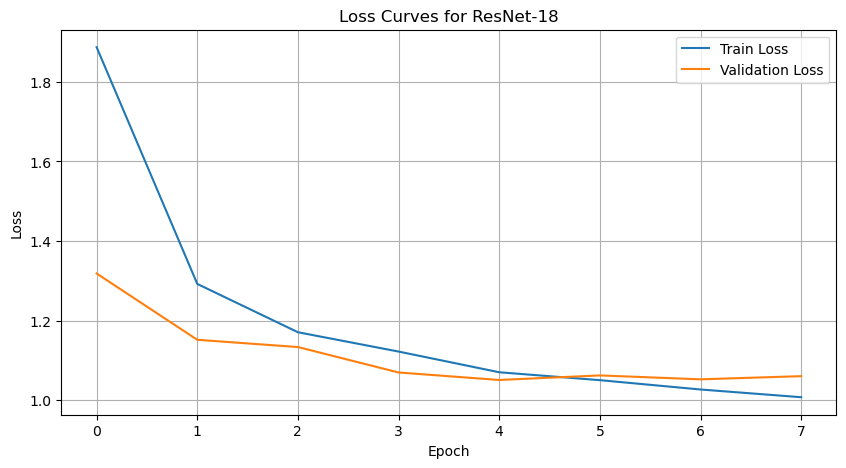


Fine-tuning EfficientNet-B0...
Epoch 1/10 | EfficientNet-B0 | Train Loss: 1.9939 | Val Loss: 1.3959 | Val Acc: 0.6340
Epoch 2/10 | EfficientNet-B0 | Train Loss: 1.4321 | Val Loss: 1.2341 | Val Acc: 0.6593
Epoch 3/10 | EfficientNet-B0 | Train Loss: 1.2991 | Val Loss: 1.1563 | Val Acc: 0.6867
Epoch 4/10 | EfficientNet-B0 | Train Loss: 1.2509 | Val Loss: 1.1111 | Val Acc: 0.6900
Epoch 5/10 | EfficientNet-B0 | Train Loss: 1.2237 | Val Loss: 1.0736 | Val Acc: 0.6993
Epoch 6/10 | EfficientNet-B0 | Train Loss: 1.1865 | Val Loss: 1.0812 | Val Acc: 0.6953
Epoch 7/10 | EfficientNet-B0 | Train Loss: 1.1801 | Val Loss: 1.0706 | Val Acc: 0.6947
Epoch 8/10 | EfficientNet-B0 | Train Loss: 1.1522 | Val Loss: 1.0563 | Val Acc: 0.6933
Epoch 9/10 | EfficientNet-B0 | Train Loss: 1.1484 | Val Loss: 1.0529 | Val Acc: 0.6933
Epoch 10/10 | EfficientNet-B0 | Train Loss: 1.1452 | Val Loss: 1.0599 | Val Acc: 0.6960
EfficientNet-B0 Test Metrics:
Accuracy:  0.6640
Precision: 0.6727
Recall:    0.6640
F1 Score:  0.

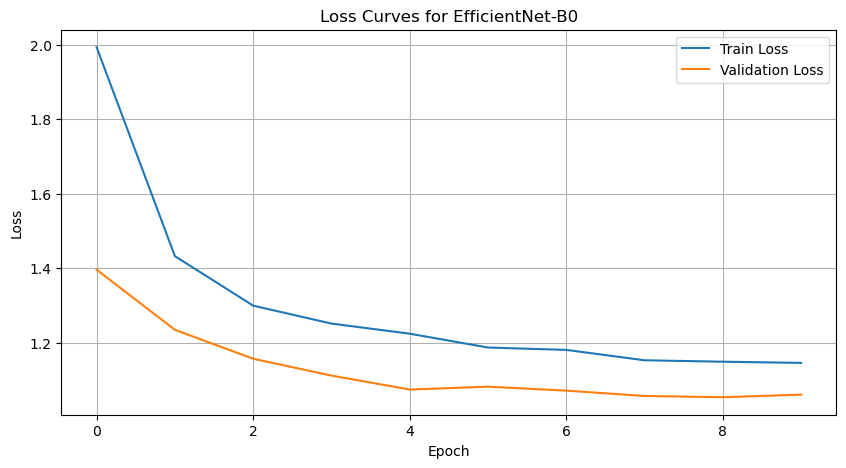


Fine-tuning MobileNetV2...
Epoch 1/10 | MobileNetV2 | Train Loss: 1.7032 | Val Loss: 1.1397 | Val Acc: 0.6907
Epoch 2/10 | MobileNetV2 | Train Loss: 1.1221 | Val Loss: 0.9776 | Val Acc: 0.7227
Epoch 3/10 | MobileNetV2 | Train Loss: 0.9906 | Val Loss: 0.9089 | Val Acc: 0.7420
Epoch 4/10 | MobileNetV2 | Train Loss: 0.9118 | Val Loss: 0.8891 | Val Acc: 0.7367
Epoch 5/10 | MobileNetV2 | Train Loss: 0.8872 | Val Loss: 0.8602 | Val Acc: 0.7420
Epoch 6/10 | MobileNetV2 | Train Loss: 0.8580 | Val Loss: 0.8445 | Val Acc: 0.7487
Epoch 7/10 | MobileNetV2 | Train Loss: 0.8352 | Val Loss: 0.8475 | Val Acc: 0.7453
Epoch 8/10 | MobileNetV2 | Train Loss: 0.8098 | Val Loss: 0.8338 | Val Acc: 0.7440
Epoch 9/10 | MobileNetV2 | Train Loss: 0.8204 | Val Loss: 0.8138 | Val Acc: 0.7580
Epoch 10/10 | MobileNetV2 | Train Loss: 0.8036 | Val Loss: 0.8245 | Val Acc: 0.7427
MobileNetV2 Test Metrics:
Accuracy:  0.7480
Precision: 0.7556
Recall:    0.7480
F1 Score:  0.7471


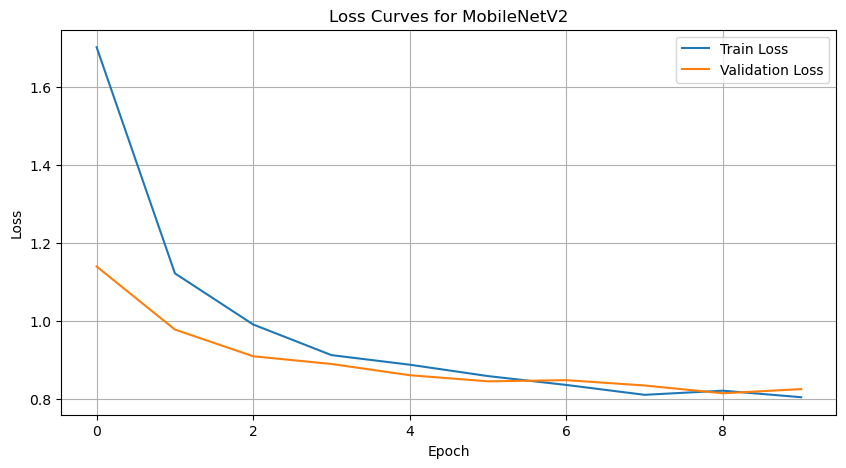


Summary of Results:
ResNet-18:
  Accuracy : 0.6560
  Precision: 0.6771
  Recall   : 0.6560
  F1-Score : 0.6566
EfficientNet-B0:
  Accuracy : 0.6640
  Precision: 0.6727
  Recall   : 0.6640
  F1-Score : 0.6627
MobileNetV2:
  Accuracy : 0.7480
  Precision: 0.7556
  Recall   : 0.7480
  F1-Score : 0.7471


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_to_fine_tune = {
    "ResNet-18": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    "EfficientNet-B0": models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT),
    "MobileNetV2": models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
}

results = {}

for model_name, model in models_to_fine_tune.items():
    print(f"\nFine-tuning {model_name}...")
    model = model.to(device)

    if model_name.startswith("ResNet"):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith("EfficientNet"):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith("MobileNetV2"):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = False

    if model_name.startswith("ResNet"):
        for param in model.fc.parameters():
            param.requires_grad = True
    elif model_name.startswith("EfficientNet"):
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif model_name.startswith("MobileNetV2"):
        for param in model.classifier.parameters():
            param.requires_grad = True

    
    train_loader = DataLoader(train_dataset, batch_size=batch_sizes[model_name], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_sizes[model_name], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_sizes[model_name], shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    
    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, model_name, num_epochs=10, patience=3
    )

    test_acc, precision, recall, f1 = evaluate_model(model, test_loader, model_name)

    plot_losses(train_losses, val_losses, model_name)

    results[model_name] = {
        "test_accuracy": test_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "train_losses": train_losses,
        "val_losses": val_losses
    }

print("\nSummary of Results:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy : {result['test_accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall   : {result['recall']:.4f}")
    print(f"  F1-Score : {result['f1']:.4f}")


## 4. Training Randomly Weighted CNN Models
 
To observe the influence of pretrained weights, we retrained all three models from scratch, initializing all weights randomly. Starting from a random state, the models had to learn all representations from the ground up.

Initially, both the training and validation accuracy were quite low. However, over 10 epochs, the model progressively improved. In the final epoch, EfficientNet-B0 achieved a **validation accuracy of 65.20% and test accuracy of 61.87%, along with precision of 64.50%, recall of 61.87%, and F1-score of 61.78%.**

As previously mentioned, we had to manage our limited computational resources carefully. Therefore, we set the number of training epochs to 10. However, the accuracy of all three models continued to improve throughout training, indicating that they had not yet reached their performance peak. It is likely that increasing the number of epochs to 20 or 30 would have led to even better results.

Additionally, it is important to note that we used only 40% of the dataset and resized the images to 128×128 pixels, both of which impacted the overall accuracy. Nevertheless, we are satisfied with the results achieved under these constraints.




Training from scratch: EfficientNet-B0
Epoch 1/10 | EfficientNet-B0 (Random Init) | Train Loss: 2.9766 | Val Loss: 2.7747 | Val Acc: 0.1040
Epoch 2/10 | EfficientNet-B0 (Random Init) | Train Loss: 2.6396 | Val Loss: 2.5129 | Val Acc: 0.2227
Epoch 3/10 | EfficientNet-B0 (Random Init) | Train Loss: 2.3498 | Val Loss: 2.2754 | Val Acc: 0.2900
Epoch 4/10 | EfficientNet-B0 (Random Init) | Train Loss: 2.1352 | Val Loss: 2.0218 | Val Acc: 0.3387
Epoch 5/10 | EfficientNet-B0 (Random Init) | Train Loss: 1.9549 | Val Loss: 1.8246 | Val Acc: 0.4153
Epoch 6/10 | EfficientNet-B0 (Random Init) | Train Loss: 1.7848 | Val Loss: 1.6378 | Val Acc: 0.4660
Epoch 7/10 | EfficientNet-B0 (Random Init) | Train Loss: 1.5964 | Val Loss: 1.4088 | Val Acc: 0.5567
Epoch 8/10 | EfficientNet-B0 (Random Init) | Train Loss: 1.4351 | Val Loss: 1.3408 | Val Acc: 0.5880
Epoch 9/10 | EfficientNet-B0 (Random Init) | Train Loss: 1.2608 | Val Loss: 1.1406 | Val Acc: 0.6473
Epoch 10/10 | EfficientNet-B0 (Random Init) | Train

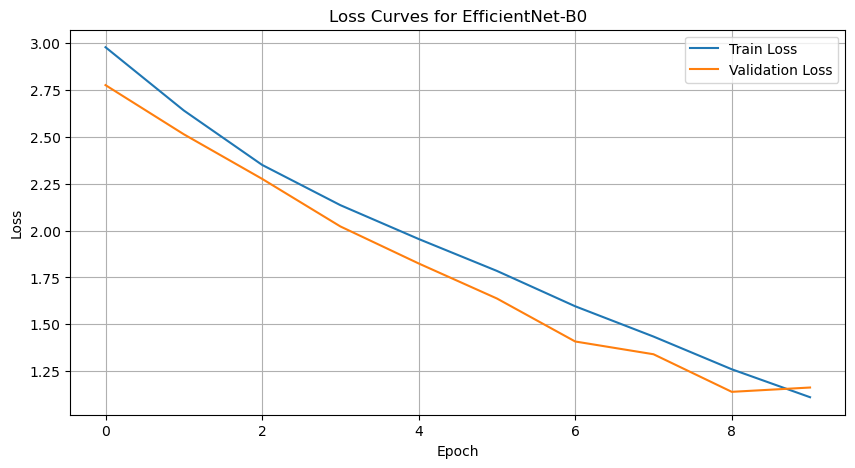


Training from scratch: ResNet-18
Epoch 1/10 | ResNet-18 (Random Init) | Train Loss: 2.6426 | Val Loss: 2.2641 | Val Acc: 0.2713
Epoch 2/10 | ResNet-18 (Random Init) | Train Loss: 2.0864 | Val Loss: 2.0203 | Val Acc: 0.3827
Epoch 3/10 | ResNet-18 (Random Init) | Train Loss: 1.7666 | Val Loss: 1.8265 | Val Acc: 0.4100
Epoch 4/10 | ResNet-18 (Random Init) | Train Loss: 1.5096 | Val Loss: 1.5861 | Val Acc: 0.5293
Epoch 5/10 | ResNet-18 (Random Init) | Train Loss: 1.3010 | Val Loss: 1.4419 | Val Acc: 0.5553
Epoch 6/10 | ResNet-18 (Random Init) | Train Loss: 1.1198 | Val Loss: 1.1985 | Val Acc: 0.6173
Epoch 7/10 | ResNet-18 (Random Init) | Train Loss: 0.9763 | Val Loss: 1.1597 | Val Acc: 0.6433
Epoch 8/10 | ResNet-18 (Random Init) | Train Loss: 0.8473 | Val Loss: 1.0289 | Val Acc: 0.6967
Epoch 9/10 | ResNet-18 (Random Init) | Train Loss: 0.7313 | Val Loss: 1.0031 | Val Acc: 0.7007
Epoch 10/10 | ResNet-18 (Random Init) | Train Loss: 0.6458 | Val Loss: 0.8768 | Val Acc: 0.7433
ResNet-18 (Rand

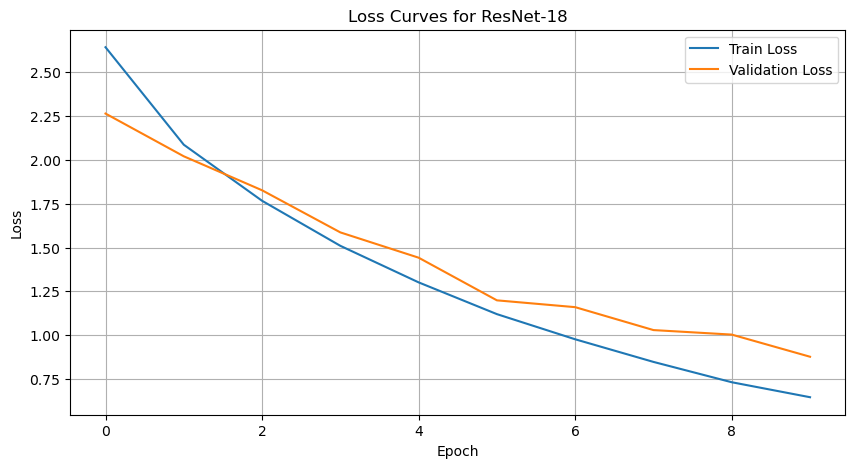


Training from scratch: MobileNetV2
Epoch 1/10 | MobileNetV2 (Random Init) | Train Loss: 2.8751 | Val Loss: 2.5010 | Val Acc: 0.2347
Epoch 2/10 | MobileNetV2 (Random Init) | Train Loss: 2.2990 | Val Loss: 2.1034 | Val Acc: 0.3307
Epoch 3/10 | MobileNetV2 (Random Init) | Train Loss: 1.9875 | Val Loss: 1.8738 | Val Acc: 0.4313
Epoch 4/10 | MobileNetV2 (Random Init) | Train Loss: 1.7560 | Val Loss: 1.5962 | Val Acc: 0.5280
Epoch 5/10 | MobileNetV2 (Random Init) | Train Loss: 1.5496 | Val Loss: 1.4235 | Val Acc: 0.5613
Epoch 6/10 | MobileNetV2 (Random Init) | Train Loss: 1.3767 | Val Loss: 1.4155 | Val Acc: 0.5767
Epoch 7/10 | MobileNetV2 (Random Init) | Train Loss: 1.2516 | Val Loss: 1.1998 | Val Acc: 0.6393
Epoch 8/10 | MobileNetV2 (Random Init) | Train Loss: 1.1428 | Val Loss: 1.1655 | Val Acc: 0.6600
Epoch 9/10 | MobileNetV2 (Random Init) | Train Loss: 1.0595 | Val Loss: 1.2862 | Val Acc: 0.6220
Epoch 10/10 | MobileNetV2 (Random Init) | Train Loss: 0.9592 | Val Loss: 1.0874 | Val Acc: 

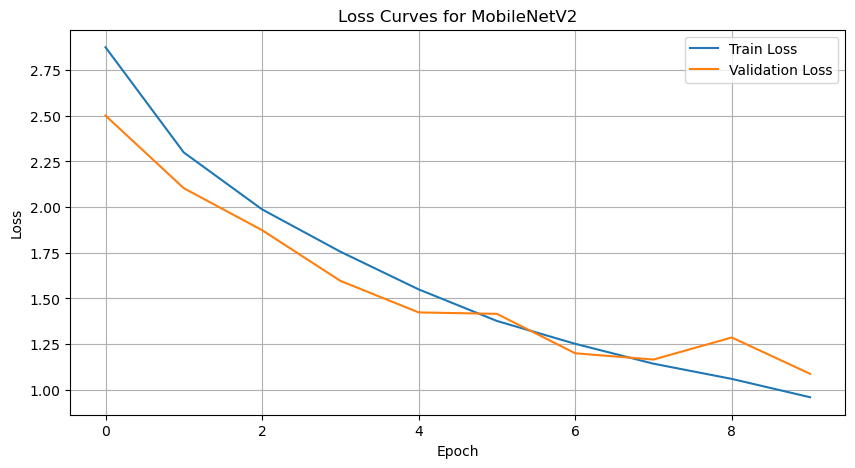

In [51]:

models_random_init = {
    "EfficientNet-B0": models.efficientnet_b0(weights=None),
    "ResNet-18": models.resnet18(weights=None),
    "MobileNetV2": models.mobilenet_v2(weights=None)
}

results_random = {}

for model_name, model in models_random_init.items():
    print(f"\nTraining from scratch: {model_name}")
    model = model.to(device)

    if model_name.startswith("ResNet"):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith("MobileNet"):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith("EfficientNet"):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = True



    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        model_name + " (Random Init)", num_epochs=10, patience=3
    )

    test_acc = evaluate_model(model, test_loader, model_name + " (Random Init)")

    plot_losses(train_losses, val_losses, model_name)

    results_random[model_name] = {
        "test_accuracy": test_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }


## 5.  Implementing and Training Your Own CNN Model from Scratch

**1. SimpleCNN**
SimpleCNN demonstrated a consistent improvement in both training and validation accuracy over the first several epochs. The training process was halted at epoch 8 due to early stopping, as validation loss began to plateau. Despite using only 40% of the dataset and 128×128 resized images, the model achieved a test accuracy of 55.6%, with a precision of 57.88%, recall of 55.6%, and F1-score of 54.94%. While not the top performer, SimpleCNN achieved reasonably good generalization for its simple structure.

**2. CNNWithDropout**
The CNNWithDropout model performed the best among the three. It showed steady improvement throughout all 15 epochs, without signs of overfitting. Regularization via dropout appears to have helped generalization. The model achieved a test accuracy of 65.13%, with a precision of 66.78%, recall of 65.13%, and an F1-score of 65.28%. This suggests that applying dropout in deeper CNN layers can significantly enhance performance in training from scratch, even under data constraints.

**3. DeepCNN**
The DeepCNN model initially struggled with convergence and achieved relatively low accuracy during the early epochs. Although it improved gradually over the course of training, the final test performance remained limited. It achieved a test accuracy of 34.27%, with a precision of 34.96%, recall of 34.27%, and an F1-score of 32.80%. These results suggest that the architecture may have been too complex to train effectively from scratch on a small dataset with limited resolution, leading to underfitting or unstable learning.



In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_size=128):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
    
        feature_size = 128 * (image_size // 8) * (image_size // 8)  
        self.fc = nn.Linear(feature_size, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNWithDropout(nn.Module):
    def __init__(self, num_classes, image_size=128):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.5)
        feature_size = 128 * (image_size // 8) * (image_size // 8)  
        self.fc = nn.Linear(feature_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)  
        x = self.conv2(x)  
        x = self.conv3(x)  
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class DeepCNN(nn.Module):
    def __init__(self, num_classes, image_size=128):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                              
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)                             
        )
        feature_size = 128 * (image_size // 8) * (image_size // 8)  
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Training from scratch: SimpleCNN
Epoch 1/15 | SimpleCNN (Custom) | Train Loss: 2.6139 | Val Loss: 2.1761 | Val Acc: 0.3447
Epoch 2/15 | SimpleCNN (Custom) | Train Loss: 1.9668 | Val Loss: 1.9309 | Val Acc: 0.4140
Epoch 3/15 | SimpleCNN (Custom) | Train Loss: 1.6472 | Val Loss: 1.6424 | Val Acc: 0.5033
Epoch 4/15 | SimpleCNN (Custom) | Train Loss: 1.4218 | Val Loss: 1.6188 | Val Acc: 0.5353
Epoch 5/15 | SimpleCNN (Custom) | Train Loss: 1.2723 | Val Loss: 1.4923 | Val Acc: 0.5653
Epoch 6/15 | SimpleCNN (Custom) | Train Loss: 1.1320 | Val Loss: 1.5228 | Val Acc: 0.5627
Epoch 7/15 | SimpleCNN (Custom) | Train Loss: 1.0334 | Val Loss: 1.4996 | Val Acc: 0.5907
Epoch 8/15 | SimpleCNN (Custom) | Train Loss: 0.9193 | Val Loss: 1.5202 | Val Acc: 0.5893
Early stopping at epoch 8 for SimpleCNN (Custom)
SimpleCNN (Custom) Test Metrics:
Accuracy:  0.5560
Precision: 0.5788
Recall:    0.5560
F1 Score:  0.5494


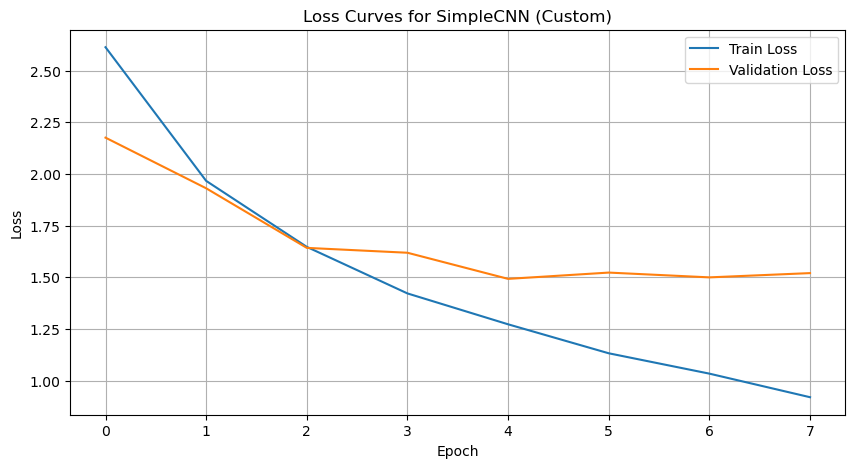


Training from scratch: CNNWithDropout
Epoch 1/15 | CNNWithDropout (Custom) | Train Loss: 4.5893 | Val Loss: 2.7392 | Val Acc: 0.2667
Epoch 2/15 | CNNWithDropout (Custom) | Train Loss: 2.4096 | Val Loss: 2.0561 | Val Acc: 0.3940
Epoch 3/15 | CNNWithDropout (Custom) | Train Loss: 1.9592 | Val Loss: 1.7633 | Val Acc: 0.4567
Epoch 4/15 | CNNWithDropout (Custom) | Train Loss: 1.7553 | Val Loss: 1.6543 | Val Acc: 0.5233
Epoch 5/15 | CNNWithDropout (Custom) | Train Loss: 1.6268 | Val Loss: 1.4953 | Val Acc: 0.5553
Epoch 6/15 | CNNWithDropout (Custom) | Train Loss: 1.4963 | Val Loss: 1.4615 | Val Acc: 0.5707
Epoch 7/15 | CNNWithDropout (Custom) | Train Loss: 1.3845 | Val Loss: 1.3714 | Val Acc: 0.6020
Epoch 8/15 | CNNWithDropout (Custom) | Train Loss: 1.2745 | Val Loss: 1.2965 | Val Acc: 0.6107
Epoch 9/15 | CNNWithDropout (Custom) | Train Loss: 1.1831 | Val Loss: 1.3226 | Val Acc: 0.6147
Epoch 10/15 | CNNWithDropout (Custom) | Train Loss: 1.1096 | Val Loss: 1.2348 | Val Acc: 0.6353
Epoch 11/1

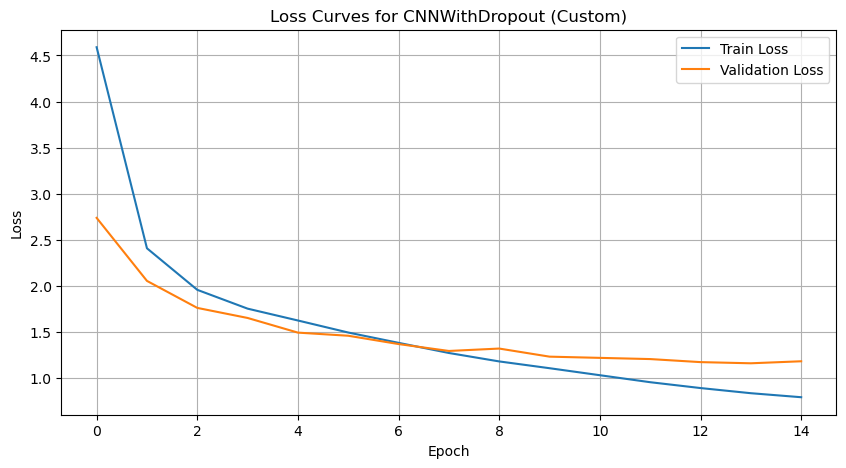


Training from scratch: DeepCNN
Epoch 1/15 | DeepCNN (Custom) | Train Loss: 3.6239 | Val Loss: 3.2052 | Val Acc: 0.0527
Epoch 2/15 | DeepCNN (Custom) | Train Loss: 3.2007 | Val Loss: 3.1435 | Val Acc: 0.0607
Epoch 3/15 | DeepCNN (Custom) | Train Loss: 3.1518 | Val Loss: 3.0924 | Val Acc: 0.0673
Epoch 4/15 | DeepCNN (Custom) | Train Loss: 3.1094 | Val Loss: 3.0595 | Val Acc: 0.0807
Epoch 5/15 | DeepCNN (Custom) | Train Loss: 3.0800 | Val Loss: 3.0645 | Val Acc: 0.0773
Epoch 6/15 | DeepCNN (Custom) | Train Loss: 3.0550 | Val Loss: 2.9361 | Val Acc: 0.1247
Epoch 7/15 | DeepCNN (Custom) | Train Loss: 2.9152 | Val Loss: 2.6184 | Val Acc: 0.1647
Epoch 8/15 | DeepCNN (Custom) | Train Loss: 2.8056 | Val Loss: 2.5681 | Val Acc: 0.1727
Epoch 9/15 | DeepCNN (Custom) | Train Loss: 2.6993 | Val Loss: 2.4465 | Val Acc: 0.2093
Epoch 10/15 | DeepCNN (Custom) | Train Loss: 2.5406 | Val Loss: 2.3536 | Val Acc: 0.2273
Epoch 11/15 | DeepCNN (Custom) | Train Loss: 2.4383 | Val Loss: 2.2651 | Val Acc: 0.254

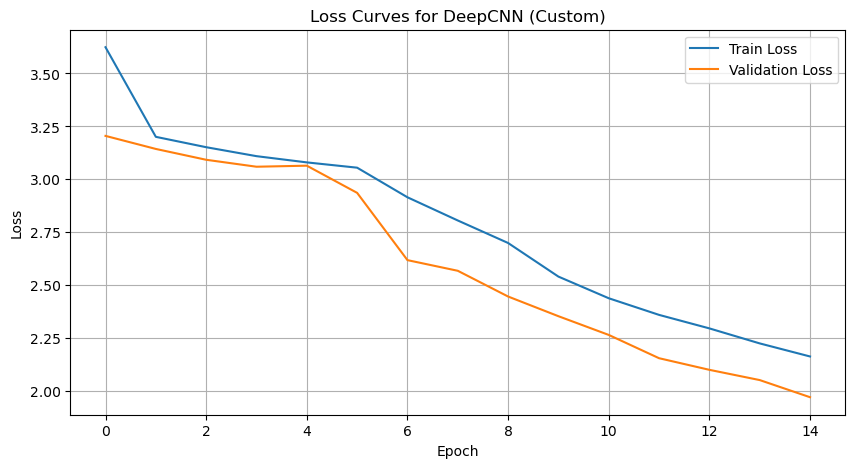


Final Summary of All Models:

=== Fine-Tuned Pretrained Models ===
ResNet-18:
  Accuracy : 0.6560
  Precision: 0.6771
  Recall   : 0.6560
  F1-Score : 0.6566
EfficientNet-B0:
  Accuracy : 0.6640
  Precision: 0.6727
  Recall   : 0.6640
  F1-Score : 0.6627
MobileNetV2:
  Accuracy : 0.7480
  Precision: 0.7556
  Recall   : 0.7480
  F1-Score : 0.7471

=== Randomly Initialized Models ===
EfficientNet-B0 (Random Init):
  Accuracy : 0.6187
  Precision: 0.6450
  Recall   : 0.6187
  F1-Score : 0.6178
ResNet-18 (Random Init):
  Accuracy : 0.7267
  Precision: 0.7553
  Recall   : 0.7267
  F1-Score : 0.7320
MobileNetV2 (Random Init):
  Accuracy : 0.6707
  Precision: 0.6978
  Recall   : 0.6707
  F1-Score : 0.6708

=== Custom CNN Models ===
SimpleCNN (Custom):
  Accuracy : 0.5560
  Precision: 0.5788
  Recall   : 0.5560
  F1-Score : 0.5494
CNNWithDropout (Custom):
  Accuracy : 0.6513
  Precision: 0.6678
  Recall   : 0.6513
  F1-Score : 0.6528
DeepCNN (Custom):
  Accuracy : 0.3427
  Precision: 0.3496
 

In [60]:
custom_models = {
    "SimpleCNN": SimpleCNN(num_classes=num_classes),
    "CNNWithDropout": CNNWithDropout(num_classes=num_classes),
    "DeepCNN": DeepCNN(num_classes=num_classes)
}

results_custom = {}

for model_name, model in custom_models.items():
    print(f"\nTraining from scratch: {model_name}")
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = True

    train_loader = DataLoader(train_dataset, batch_size=batch_sizes["ResNet-18"], shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_sizes["ResNet-18"], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_sizes["ResNet-18"], shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        model_name + " (Custom)", num_epochs=15, patience=3
    )

    test_acc, precision, recall, f1 = evaluate_model(model, test_loader, model_name + " (Custom)")

    plot_losses(train_losses, val_losses, model_name + " (Custom)")

    results_custom[model_name] = {
        "test_accuracy": test_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "train_losses": train_losses,
        "val_losses": val_losses
    }

print("\nFinal Summary of All Models:")
print("\n=== Fine-Tuned Pretrained Models ===")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy : {result['test_accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall   : {result['recall']:.4f}")
    print(f"  F1-Score : {result['f1']:.4f}")

print("\n=== Randomly Initialized Models ===")
for model_name, result in results_random.items():
    print(f"{model_name} (Random Init):")
    print(f"  Accuracy : {result['test_accuracy'][0]:.4f}")
    print(f"  Precision: {result['test_accuracy'][1]:.4f}")
    print(f"  Recall   : {result['test_accuracy'][2]:.4f}")
    print(f"  F1-Score : {result['test_accuracy'][3]:.4f}")

print("\n=== Custom CNN Models ===")
for model_name, result in results_custom.items():
    print(f"{model_name} (Custom):")
    print(f"  Accuracy : {result['test_accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall   : {result['recall']:.4f}")
    print(f"  F1-Score : {result['f1']:.4f}")

all_models = {
    **{f"{k} (Fine-Tuned)": v['test_accuracy'] for k, v in results.items()},
    **{f"{k} (Random Init)": v['test_accuracy'][0] for k, v in results_random.items()},
    **{f"{k} (Custom)": v['test_accuracy'] for k, v in results_custom.items()}
}




## 7. Review and conclusion

Overall, the feature extraction approach achieved the highest accuracy among all methods. However, we strongly believe that utilizing the full dataset, preserving the original image resolution, and training with a sufficiently large batch size in CNN would likely get even better accuracy. According to our results,

**Best Model:** Random Forest with raw color histograms (0.8349 accuracy) outperforms all others, showing feature extraction can be highly effective when well-designed.

**Deep Learning:** Fine-tuned MobileNetV2 (0.7480 accuracy) and randomly initialized ResNet-18 (0.7267 accuracy) are strong, but don’t surpass color histograms with Random Forest.

**Custom CNNs:** CNNWithDropout (0.6513 accuracy) is competitive but not superior to pretrained models or feature extraction

**Weak Performers:** Color and Gabor features perform poorly, as do their PCA/FS variants. DeepCNN struggles, likely due to complexity and limited data.


Throughout the semester, we believe we have carried out valuable machine learning applications and gained important skills. We would like to thank you for your contributions to this process.
